### Table of Contents

* [Install libraries](#install_libraries)
* [Imports](#imports)
* [Read data](#read_data)
* [Dataset & Dataloader](#dataset_dataloader)
* [Model](#model)
* [Training](#training)
* [Results](#results)
* [Improvements](#improvements)
* [Demo](#demo)
* [Save & Load model](#save_load_model)

I wanted to use cats vs dogs dataset from [here](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads) since it had some [problems](https://github.com/huggingface/datasets/issues/4032) I'm using [car dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset) from kaggle.

P.S can we use it for car crash detection? interesting

# **Install libraries** <a class="anchor" id="install_libraries"></a>

In [1]:
%%time
%%capture
# install libraries
! pip install -q kaggle
! pip install wandb --upgrade
! pip install timm
! pip install albumentations==1.1.0
! pip install gradio

# download kaggle dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/stanford-cars-dataset
! unzip stanford-cars-dataset.zip

CPU times: user 1.03 s, sys: 265 ms, total: 1.29 s
Wall time: 2min 17s


In [ ]:
# there was error about albumentations and cv2 thats why I need this specific version
! pip uninstall opencv-python-headless==4.5.5.62 
! pip install opencv-python-headless==4.1.2.30

# **Imports** <a class="anchor" id="imports"></a>

In [1]:
import os
import gc
import numpy as np
from tqdm import tqdm
from pathlib import Path
from functools import partial
from collections import Counter

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import albumentations.pytorch

import wandb
import gradio as gr
from IPython.display import display
from ipywidgets import widgets

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# use weights & biases to track our experiments

wandb.login()

wandb: Currently logged in as: raphaelkalandadze (use `wandb login --relogin` to force relogin)


True

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
set_seed()

In [5]:
CONFIG = dict(
    model_name = 'efficientnet_b0',
    img_size = 128,
    num_classes = 2,
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    num_epochs = 3,
    train_batch_size = 64,
    valid_batch_size = 128,
    n_accumulate = 1,
    # learning_rate_scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=100, eta_min=1e-6),
    learning_rate_scheduler = None,
    learning_rate = 1e-4,
    weight_decay = 1e-6)

In [6]:
PATH_ROOT = Path(".")

PATH_TRAIN = PATH_ROOT/"cars_train"/"cars_train"
PATH_TEST = PATH_ROOT/"cars_test"/"cars_test"

VOCAB = ["normal", "upside"]

# **Read data** <a class="anchor" id="read_data"></a>

In [7]:
# load image path

train_images = [PATH_TRAIN/img_name for img_name in os.listdir(PATH_TRAIN)]
test_images = [PATH_TEST/img_name for img_name in os.listdir(PATH_TEST)]

print(f"train data size - {len(train_images)}")
print(f"test data size - {len(test_images)}")

train data size - 8144
test data size - 8041


use 2 steps for data processing:
1. The size of the train and test data is equal, so I will merge them and divide again, since we do not need so much test data
2. Since we need upside down images, I duplicated the data, but labeled it as 1, so we have every image twice, one upside and one normal.

In [8]:
train_test_images = train_images + test_images
train_test_images_label = [1]*len(train_test_images)

all_images = train_test_images + train_test_images 
all_labels = train_test_images_label + [0]*len(train_test_images)

train_images, test_images, train_images_label, test_images_label = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

print("train set distribution", Counter(train_images_label))
print("test set distribution", Counter(test_images_label))

train set distribution Counter({1: 12960, 0: 12936})
test set distribution Counter({0: 3249, 1: 3225})


In [9]:
train = list(zip(train_images, train_images_label))
test = list(zip(test_images, test_images_label))

# **Dataset & Dataloader** <a class="anchor" id="dataset_dataloader"></a>

In [10]:
class CarsDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = self.img_dir/img_name
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if label:
          image = cv2.rotate(image, cv2.ROTATE_180)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label, str(img_path)

In [11]:
train_transform = A.Compose([
                             A.Resize(CONFIG['img_size'], CONFIG['img_size']),
                             A.HorizontalFlip(),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.1, 0.1), 
                                 contrast_limit=(-0.1, 0.1)),
                             A.augmentations.geometric.transforms.ShiftScaleRotate(
                                 shift_limit=(-0.1, 0.1),
                                 rotate_limit=(-30,30),
                                 scale_limit=(-0.2, 0.2)),
                             A.Normalize(
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225], 
                                max_pixel_value=255.0, 
                                p=1.0),
                             A.pytorch.transforms.ToTensorV2()], p=1.)


valid_transform = A.Compose([
                            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
                            A.Normalize(
                                    mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225], 
                                    max_pixel_value=255.0, 
                                    p=1.0),
                            A.pytorch.transforms.ToTensorV2()], p=1.)


train_dataset = CarsDataset(data=train, img_dir=PATH_ROOT, transform=train_transform)
valid_dataset = CarsDataset(data=test, img_dir=PATH_ROOT, transform=valid_transform)

train_dataloader = DataLoader(train_dataset, batch_size=CONFIG["train_batch_size"], num_workers=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CONFIG["valid_batch_size"], num_workers=2, shuffle=True)

just see some of the images to familiarise ourselves

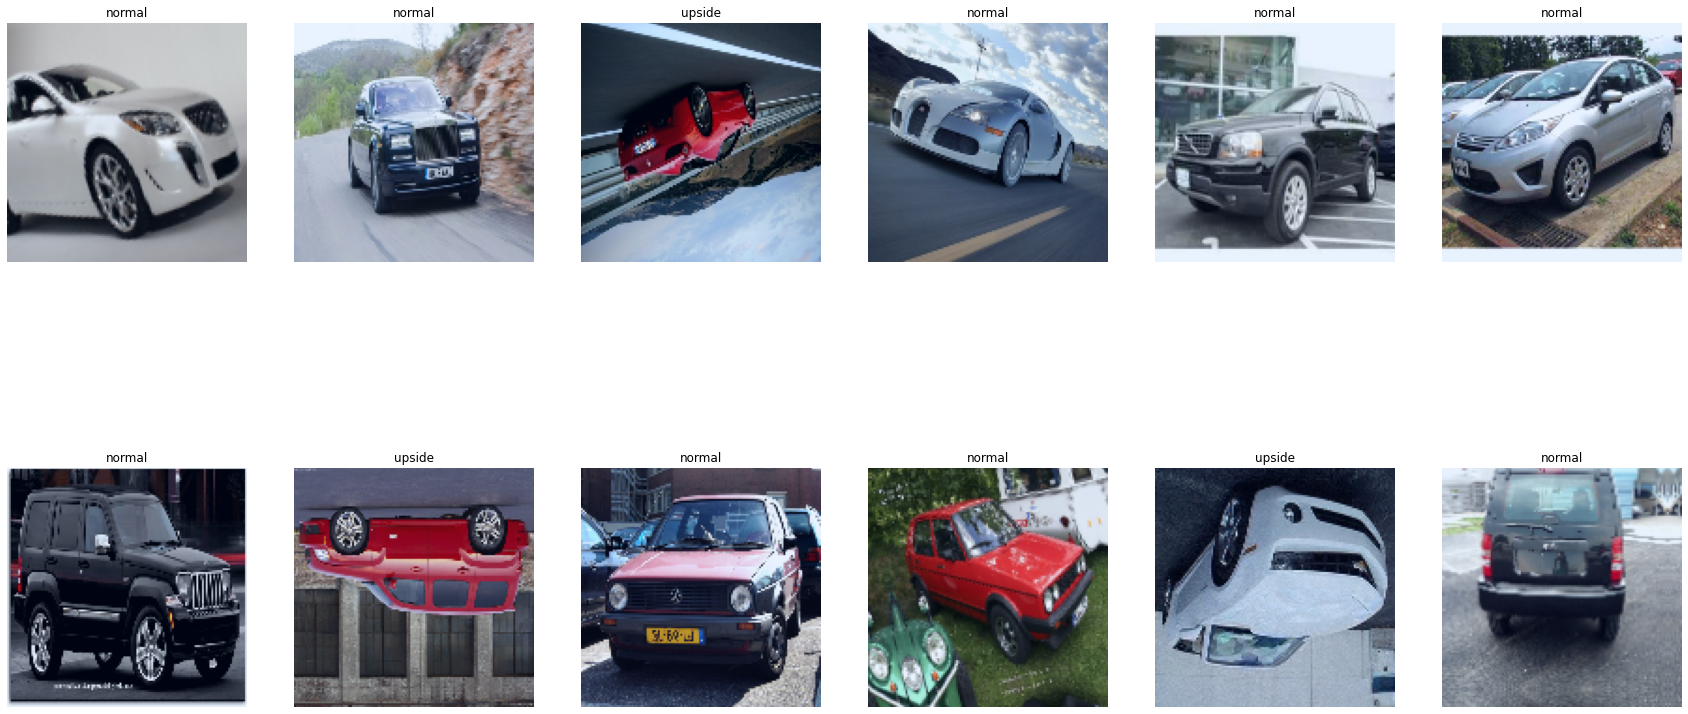

In [12]:
figure = plt.figure(figsize=(30, 15))
cols, rows = 6, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label, _ = train_dataset[sample_idx]
    img = img.permute(1,2,0)
    img = img-img.min()
    img /= img.max()
    figure.add_subplot(rows, cols, i)
    plt.title(VOCAB[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# **Model** <a class="anchor" id="model"></a>

In [13]:
class CarModel(torch.nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super(CarModel, self).__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained,  num_classes=num_classes)
        # in_features = self.model.classifier.in_features
        # self.model.classifier = torch.nn.Linear(in_features, num_classes)
        
    def forward(self, images):
        out = self.model(images)
        return out

# **Training** <a class="anchor" id="training"></a>

In [14]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, loss_fn, epoch, device):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    n_correct = 0
    
    bar = tqdm(dataloader, total=len(dataloader))
    for data in bar:        
        X = data[0].to(device, dtype=torch.float)
        y = data[1].to(device, dtype=torch.long)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        # calculate loss
        batch_size = X.size(0)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        # calculate accuracy
        _, pred = torch.max(pred, 1)
        n_correct += (pred == y).sum().item()
        epoch_accuracy = 100 * n_correct / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Accuracy=epoch_accuracy)
        
    gc.collect()
    torch.cuda.empty_cache()
    return epoch_loss, epoch_accuracy

In [15]:
def train_one_epoch(model, dataloader, optimizer, scheduler, loss_fn, epoch, n_accumulate, device):
    model.train()
    dataset_size = 0
    running_loss = 0.0
    n_correct = 0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        X = data[0].to(device, dtype=torch.float)
        y = data[1].to(device, dtype=torch.long)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        loss = loss / n_accumulate
        loss.backward()

        if (step + 1) % n_accumulate == 0:
          optimizer.step()
          optimizer.zero_grad()

          if scheduler is not None:
                scheduler.step()

        # calculate loss
        batch_size = X.size(0)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        # calculate accuracy
        _, pred = torch.max(pred, 1)
        n_correct += (pred == y).sum().item()
        epoch_accuracy = 100 * n_correct / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Accuracy=epoch_accuracy)         
    
    gc.collect()
    torch.cuda.empty_cache()
    return epoch_loss, epoch_accuracy

In [16]:
def run_training(model, train_loader, valid_loader, optimizer, scheduler, loss_fn, num_epoch, n_accumulate, device):
    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    for epoch in range(num_epoch): 
        train_epoch_loss, train_epoch_accuracy = train_one_epoch(model, train_loader, optimizer, scheduler, loss_fn, epoch, n_accumulate, device)
        val_epoch_loss, valid_epoch_accuracy = valid_one_epoch(model, valid_loader, loss_fn, epoch, device)

        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Train Accuracy": train_epoch_accuracy})

        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": valid_epoch_accuracy})

In [17]:
model = CarModel(model_name=CONFIG["model_name"],
                        num_classes=CONFIG["num_classes"])
model.to(CONFIG['device']);

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
scheduler = CONFIG["learning_rate_scheduler"](optimizer) if CONFIG["learning_rate_scheduler"] is not None else None

In [18]:
run = wandb.init(project='FatimaFellowship', 
                 config=CONFIG,
                 job_type='Train',
                 tags=['effnet-b0', '128'],
                 anonymous='must')


run_training(model, train_dataloader, valid_dataloader, 
             optimizer, scheduler, loss_fn, 
             CONFIG["num_epochs"], CONFIG["n_accumulate"], CONFIG["device"])

[INFO] Using GPU: Tesla K80



100%|██████████| 51/51 [00:54<00:00,  1.07s/it, Epoch=2, Valid_Accuracy=99.7, Valid_Loss=0.0118]


In [19]:
run.finish()

# **Results** <a class="anchor" id="results"></a>

Let's see what kind of images are predicted incorrectly

In [20]:
@torch.inference_mode()
def get_wrong_prediction(model, dataloader, device):
  model.eval()
  missed_preds = []

  bar = tqdm(dataloader, total=len(dataloader))
  for data in bar:        
      X = data[0].to(device, dtype=torch.float)
      y = data[1].to(device, dtype=torch.long)
      
      pred = model(X)
      _, pred = torch.max(pred, 1)

      path = np.array(data[2])
      missed_idx = (pred != y)
      missed_preds.append(path[missed_idx.cpu().detach().numpy()])

  missed_preds = np.concatenate(missed_preds, axis=0)
  return missed_preds

In [21]:
def show_wrong_prediction(model, dataloader, device):
  missed_preds = get_wrong_prediction(model, dataloader, device)
  print(f"\nmissed {len(missed_preds)} number of images from {len(valid_dataloader)*CONFIG['valid_batch_size']}")

  items = [widgets.Image(value=open(img, "rb").read(), format='jpg', width=CONFIG["img_size"], height=CONFIG["img_size"]) for img in missed_preds]

  box_layout = widgets.Layout(overflow_x='scroll', width='1500px')
  carousel = widgets.Box(children=items, layout=box_layout)
  display(carousel)

Incorrect predictors from validation data 

In [22]:
show_wrong_prediction(model, valid_dataloader, CONFIG["device"])

100%|██████████| 51/51 [00:56<00:00,  1.10s/it]



missed 17 number of images from 6528


Box(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x0…

Incorrect predictors from training data 

In [23]:
show_wrong_prediction(model, train_dataloader, CONFIG["device"])

100%|██████████| 405/405 [03:52<00:00,  1.74it/s]



missed 57 number of images from 6528


Box(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x0…

# **Improvements** <a class="anchor" id="improvements"></a>

As we can see, the model mispredicts such photos where there are multiple cars or that have rear views some of them are blurred or noisy

Several improvements can be made:

1. more data. Gather more types of images
2. more augmentation. for example add MultiplicativeNoise, MotionBlur, GridDistortion or zoom would be great
3. cross validation
4. images with higher dimensions. for example use 256. Images with 128 dimensions lose a lot of information, especially for large images.
5. HyperParameter Tuning. Considering how little tuning I've done, it may be worthwhile to investigate.

I am not discussing more powerful or multiple models because they are unnecessary 

# **Demo** <a class="anchor" id="demo"></a>

In [ ]:
@torch.inference_mode()
def classify(img):
  img = cv2.resize(img, (CONFIG["img_size"],CONFIG["img_size"]), interpolation=cv2.INTER_AREA)
  img = np.transpose(img, (2,0,1))
  img = np.expand_dims(img, axis=0)
  img = torch.tensor(img).to(CONFIG["device"], dtype=torch.float)
  pred = model(img)
  pred = torch.nn.Softmax()(pred)[0]
  return {VOCAB[i]: float(pred[i]) for i in  range(len(pred))}


interface = gr.Interface(fn=classify, inputs="image", outputs=gr.outputs.Label(), live=True)
interface.launch(debug=True, share=True)

# **Save & Load model** <a class="anchor" id="save_load_model"></a>

In [25]:
# save model
torch.save(model.state_dict(), f'fatima_fellowship_{CONFIG["model_name"]}.pth')

In [ ]:
# load model
model_path = "." # replace model path

model = CarModel(model_name=CONFIG["model_name"],
                 num_classes=CONFIG["num_classes"])


model.load_state_dict(torch.load(model_path))
model.to(CONFIG["device"])
model.eval();